# Construction of Scenes

- notebook to test settings (field&drifters filtering...) on one trajectory before generating all scenes

#### Imports

In [1]:
import sys
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import xarray as xr

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from utils_plots import plot_scene
import Drifters_processing
 
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

## Data and utils

In [2]:
# L3 field data

ds_swot_liss_3point5km = xr.open_dataset('../save_data/fields_data/field_L3SWOT_3point5km_Noneh.nc')

field = ds_swot_liss_3point5km


# SVP Drifters
path_drifters = '../save_data/drifters'
FILES_SVP

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

## One trajectory processing

special traj : move around the swath

xr.open_dataset(os.path.join(L2_dir, file_svp30min[3])).isel(id=5).dropna(dim='time', how='any', subset=['u'])

In [3]:
one_trajectory = open_one_traj(path_drifters, FILES_SVP[0], idx_id= 0, L3_cleaning=True, padd_swath=0.25)
one_trajectory

<xarray.Dataset>
Dimensions:  (time: 1242)
Coordinates:
    id       <U15 '300534061395960'
  * time     (time) datetime64[ns] 2023-05-04T20:30:00 ... 2023-05-30T17:00:00
    dt       float64 1.8e+03
Data variables:
    u        (time) float64 0.04412 0.04457 0.04103 ... -0.08004 -0.08155
    v        (time) float64 0.08516 0.0805 0.0887 ... -0.2575 -0.2587 -0.2666
    lon      (time) float64 4.928 4.929 4.93 4.931 ... 4.684 4.683 4.682 4.68
    lat      (time) float64 40.84 40.84 40.84 40.84 ... 40.68 40.68 40.67 40.67
Attributes:
    traj_id:  file=L2_svp_scripps_10min_lowess_30min_v0.nc ; idx_id=0

In [4]:
# get filtered drifter and field interpolation
one_trajectory = one_trajectory.where(isnear_swath(one_trajectory.lon, one_trajectory.lat, dlon=0.50), drop=True) # be sure to remove parts of the trajectory too far from the swath

one_trajectory = Drifters_processing.one_trajectory_filtering_and_field_comparison(traj=one_trajectory, 
                                                                                   field=field,
                                                                                   interp_func=interp_linear_velocity_field_L3, 
                                                                                   filtering_velocities=True,
                                                                                   low_pass_cutoff= 1/(48*3600),
                                                                                   filtering_positions=False,
                                                                                   )

# keep the part of the trajectory in the swath
one_trajectory = one_trajectory.where(isin_swath(one_trajectory.lon_filtered, one_trajectory.lat_filtered), drop=True)

# cut into chunks-scenes
scenes = Drifters_processing.get_scenes_from_traj(one_trajectory)
scenes = Drifters_processing.add_metrics(scenes)
scenes

<xarray.Dataset>
Dimensions:               (scene: 6, s_obs: 144)
Dimensions without coordinates: scene, s_obs
Data variables: (12/24)
    v_geo_swot            (scene, s_obs) float64 0.06969 0.07455 ... nan nan
    lon_filtered          (scene, s_obs) float64 4.923 4.928 ... 4.713 4.709
    time                  (scene, s_obs) datetime64[ns] 2023-05-05T12:30:00 ....
    v_filtered            (scene, s_obs) float64 0.1787 0.1772 ... -0.07097
    v                     (scene, s_obs) float64 0.2761 0.2449 ... 0.03687
    u_filtered            (scene, s_obs) float64 0.0983 0.1022 ... -0.03019
    ...                    ...
    metric_normdrift_geo  (scene, s_obs) float64 1.169 1.093 1.029 ... nan nan
    angle_var             (scene, s_obs) float64 1.457 1.369 1.289 ... nan nan
    norm_ratio_var        (scene, s_obs) float64 0.796 0.7733 0.7539 ... nan nan
    metric_var            (scene, s_obs) float64 0.1676 0.1641 ... nan nan
    metric_normmean_var   (scene, s_obs) float64 0.6711 0.64 0.6112 ... nan nan
    metric_normdrift_var  (scene, s_obs) float64 1.205 1.135 1.072 ... nan nan
Attributes:
    traj_id:    file=L2_svp_scripps_10min_lowess_30min_v0.nc ; idx_id=0
    filtering:  filtering_velocities=True, low_pass_cutoff=5.787037037037037e...

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


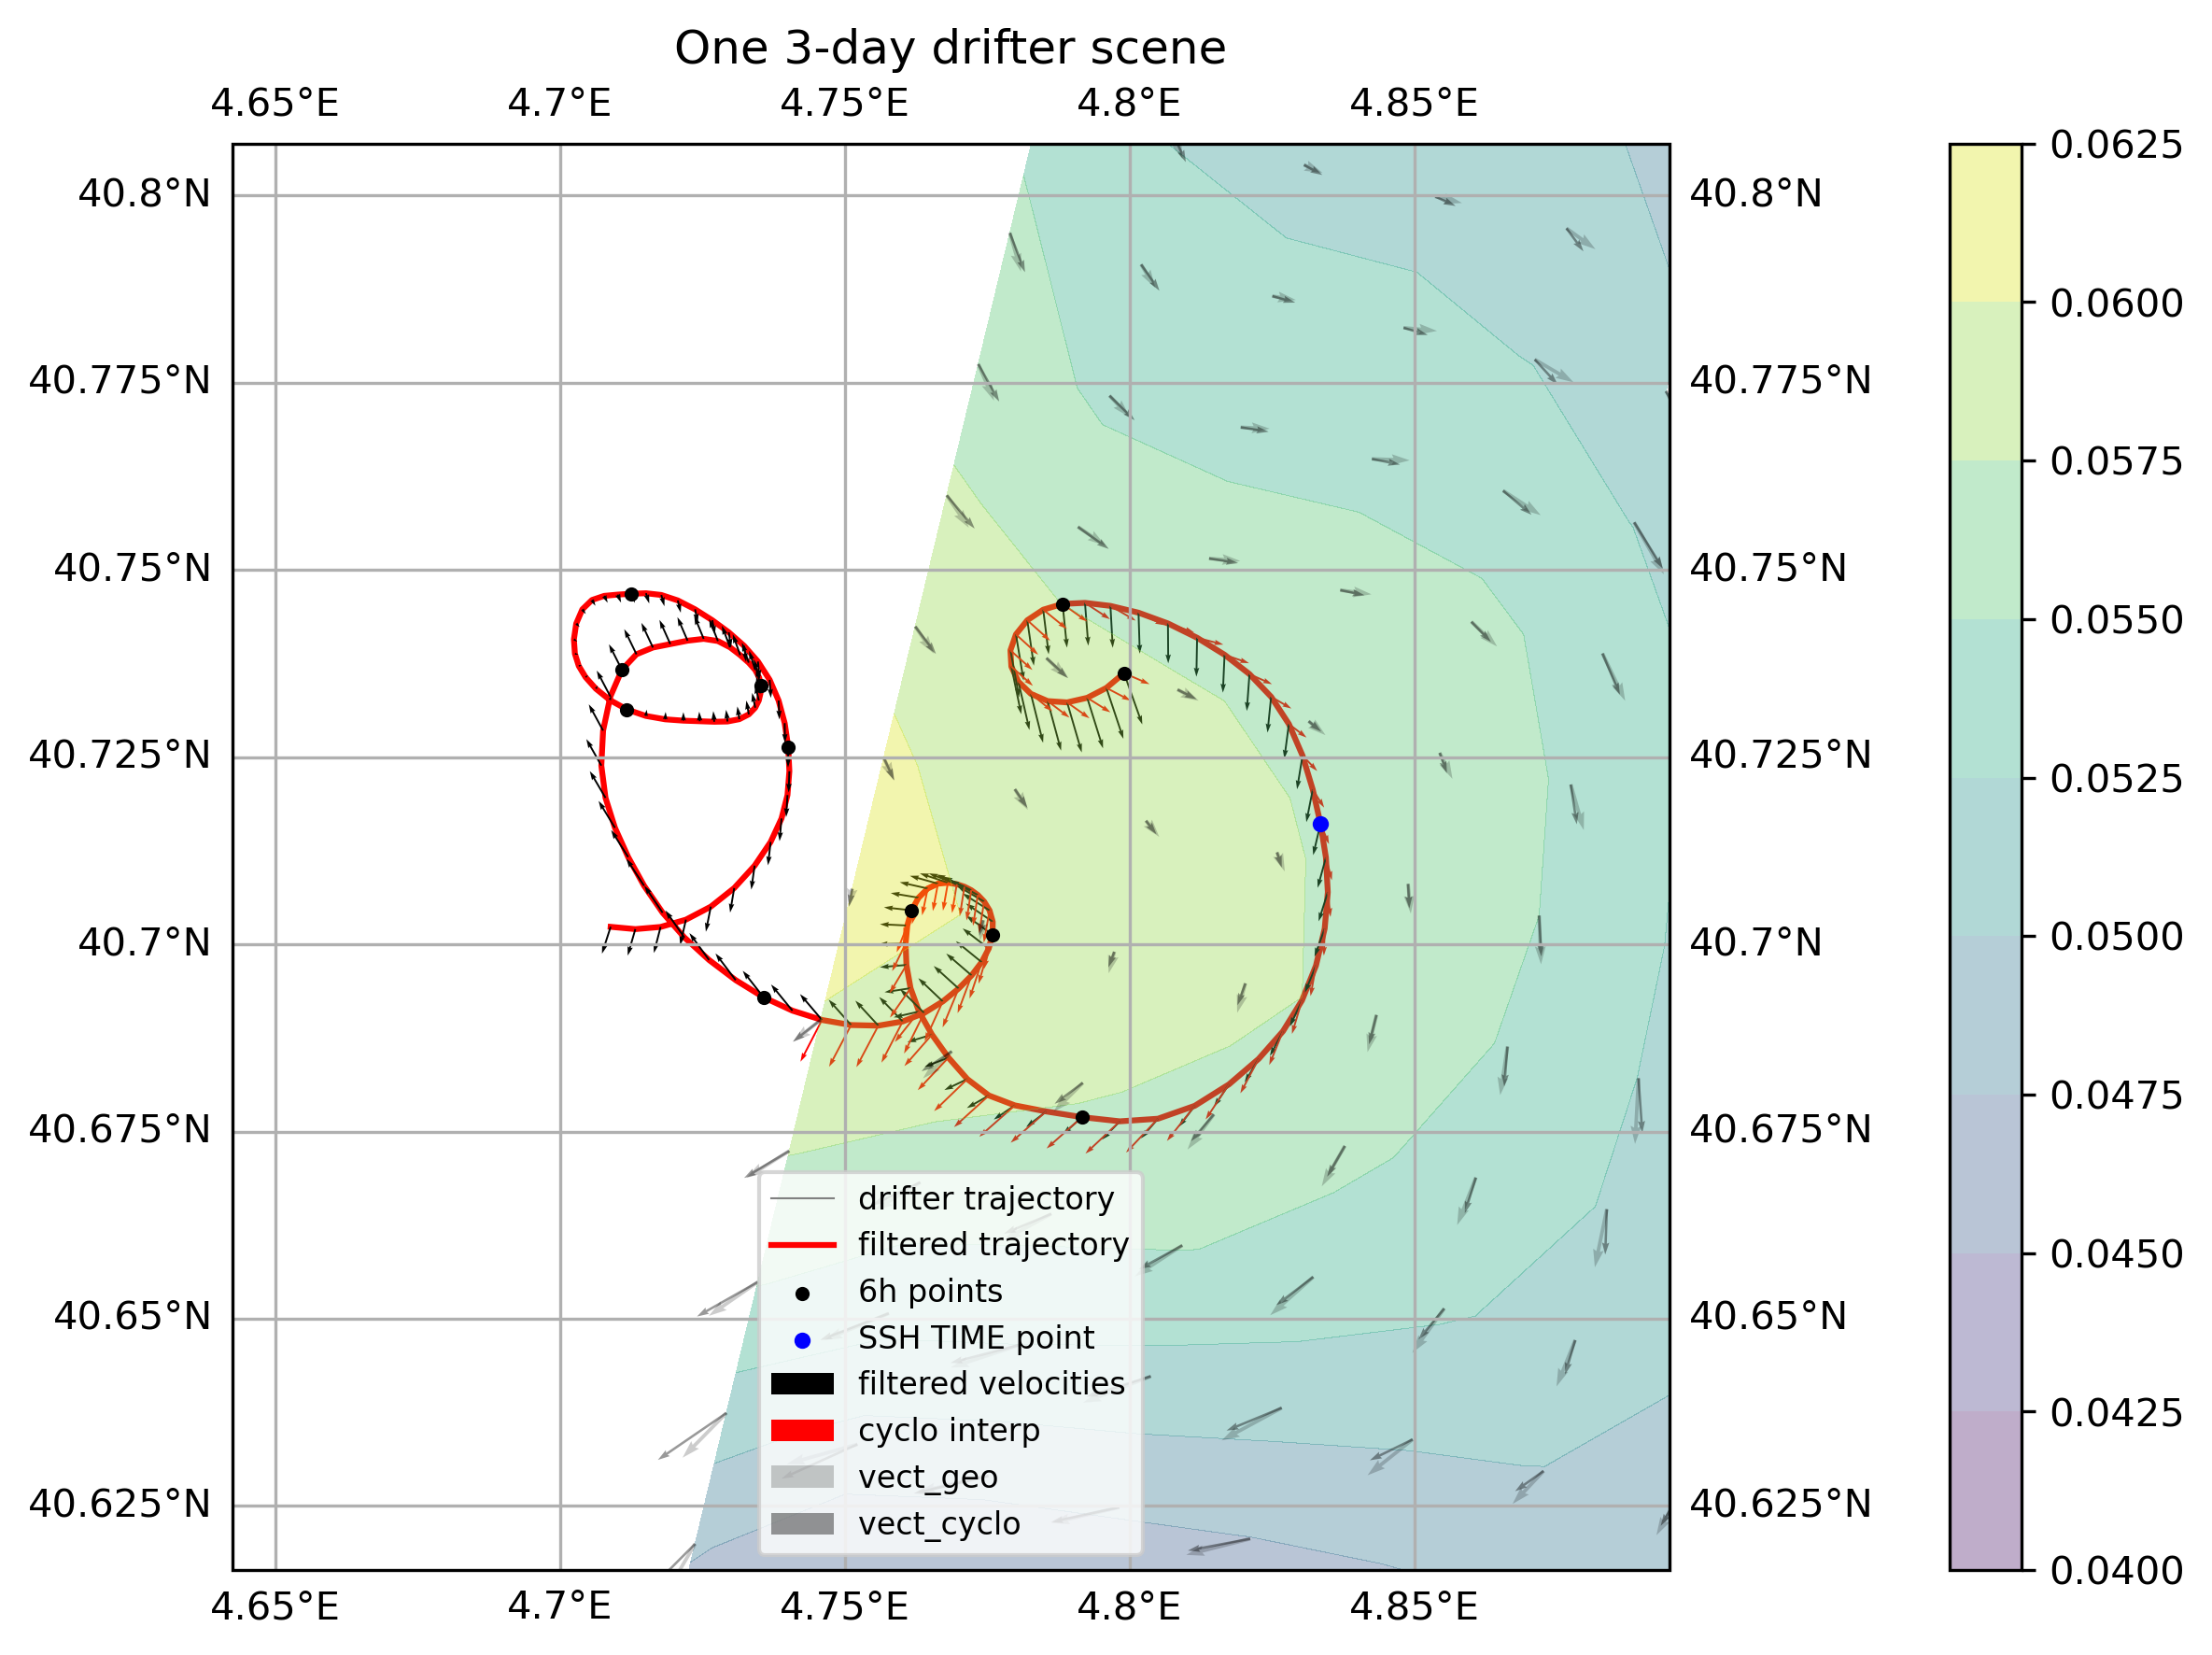

In [10]:
plot_scene(scenes.isel(scene=5), field, field_vec='both', time_point=2, points_hours=6, plot=True)

## Process all files

In [5]:
##################

field = add_Tgrid_velocities(field, replace=True)

NAME = '2024-07-16_3point5km_field_36hdrifter'
path_save_data = 'save_data/drifters_scenes/Scene_3point5kmfilterfield_36hfilterdrifter'
verbose = True

##################


for id_file in range(3, len(FILES_SVP)):
    ds = xr.open_dataset(os.path.join(L2_dir, FILES_SVP[id_file]))
    num_idx = ds.sizes['id']
    del ds

    for idx_id in range(1, 27):#num_idx):
        if verbose:
            print('Processing file {:02d}/{} id {:02d}/{}'.format(id_file, len(FILES_SVP)-1, idx_id, num_idx-1) )

        traj = open_one_traj(L2_dir, FILES_SVP[id_file], idx_id=idx_id, L3_cleaning=True, padd_swath=0.25)

        if type(traj) == float : #open_one_traj returns np.nan if the trajectory is not in swath
            if verbose:
                print('traj not in swath\n')

        else:            
            
            time_span = ( traj.time.values.max() - traj.time.values.min() ) /1e9 /24 /3600
            
            if time_span > 5: #only long enough trajectories (5days)

                traj = traj.where(isnear_swath(traj.lon, traj.lat, dlon=0.30), drop=True)
                traj = Drifters_processing.one_trajectory_filtering_and_field_comparison(
                                                                                        traj=traj, 
                                                                                        field=field,
                                                                                        interp_func=interp_linear_velocity_field_L3, 
                                                                                        filtering_velocities=True,
                                                                                        low_pass_cutoff= 1/(36*3600),
                                                                                        filtering_positions=False,
                                                                                        )

                traj = traj.where(isin_swath(traj.lon_filtered, traj.lat_filtered), drop=True)
                scenes = Drifters_processing.get_scenes_from_traj(traj)
                #scenes = Drifters_processing.add_metrics(scenes)
                
                # --- SAVE
                scenes.to_netcdf(os.path.join(path_save_data, '{}_file_{}_idxid_{}.nc'.format(NAME, id_file, idx_id)))

            elif verbose:
                print('traj too small')

Processing file 03/5 id 01/27
traj not in swath

Processing file 03/5 id 02/27
Processing file 03/5 id 03/27
Processing file 03/5 id 04/27
traj too small
Processing file 03/5 id 05/27
Processing file 03/5 id 06/27
Processing file 03/5 id 07/27
Processing file 03/5 id 08/27
Processing file 03/5 id 09/27
Processing file 03/5 id 10/27


KeyboardInterrupt: 